In [1]:
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
from torch_geometric.loader import DataLoader
import os
from torch_geometric.nn import Sequential, GCNConv,GATConv
import matplotlib.pyplot as plt
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, accuracy_score
import time
import MyData as data
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression


from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import GNN_model

In [2]:
num_ly=3
hidden_size = 64*num_ly
sel_alg=3
num_to_reduce=64
view='xz'
folder_pkl='bigger_event_GCN_2'

In [3]:
%%time
data=data.dataset_preparation(root='/lustrehome/federicacuna/TB_Sept_2023_ml/Data/preprocessed/')
if view=='xz':
    fname='pi-_10GeV_4ly_1e-4_inclined_viewx'
else:
    fname='pi-_10GeV_4ly_1e-4_inclined_viewy'
# data_trk=data.get_more_file(0,105,fname)
# train_dataset = data_trk
# val_dataset =data.get_more_file(130,151,fname)
# test_dataset =data.get(160,fname)
data_trk=data.get_more_file(0,205,fname)
train_dataset = data_trk
val_dataset =data.get_more_file(230,271,fname)
test_dataset =data.get(360,fname)
print('len_train_dataset ',len(train_dataset))
print('len_val_dataset ',len(val_dataset))
print('len_test_dataset ',len(test_dataset))

file 31 not found
file 81 not found
taking a list of file from  0  to  105
file 150 not found
taking a list of file from  130  to  151
taking the  data_160.pt
len_train_dataset  1029974
len_val_dataset  199998
len_test_dataset  10000
CPU times: user 3min 25s, sys: 5.9 s, total: 3min 31s
Wall time: 5min 4s


0.6812580759723714
0.3187419240276286
CPU times: user 4.21 s, sys: 149 ms, total: 4.36 s
Wall time: 4.4 s


<BarContainer object of 2 artists>

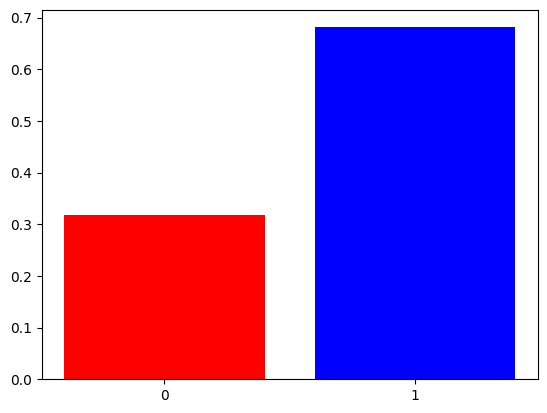

In [4]:
%%time
#check the dataset
y_values = [item for data in train_dataset for item in data.y.tolist()]
total_nodes = sum([len(data.y.tolist()) for data in train_dataset])
count_1 = y_values.count(1)/total_nodes
count_0 = y_values.count(0)/total_nodes
print(count_1)
print(count_0)
# Crea il plot a barre
plt.bar(['0', '1'], [count_0, count_1], color=['red', 'blue'])

0.6836612669323073
0.3163387330676926
CPU times: user 830 ms, sys: 8.88 ms, total: 839 ms
Wall time: 838 ms


<BarContainer object of 2 artists>

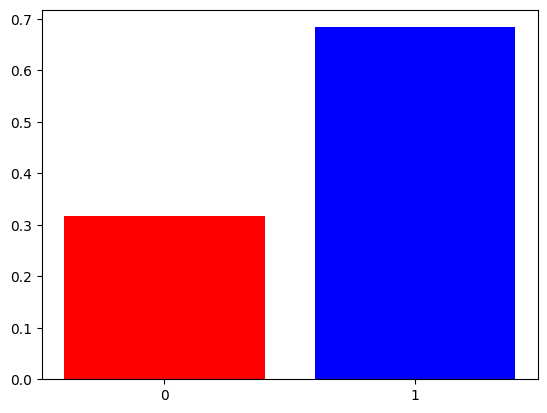

In [5]:
%%time
y_values = [item for data in val_dataset for item in data.y.tolist()]
total_nodes = sum([len(data.y.tolist()) for data in val_dataset])
count_1 = y_values.count(1)/total_nodes
count_0 = y_values.count(0)/total_nodes
print(count_1)
print(count_0)
# Crea il plot a barre
plt.bar(['0', '1'], [count_0, count_1], color=['red', 'blue'])

In [4]:
%%time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda
NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
CPU times: user 6.58 ms, sys: 39 ms, total: 45.5 ms
Wall time: 48.9 ms


In [5]:
%%time
NUM_FEATURES = train_dataset[0].x.shape[1]
print(NUM_FEATURES)
NUM_CLASSES =1
n_ly=4
model_list=['SageConv','SageConv2','GCN','GCN_2','GAT']

5
CPU times: user 61 µs, sys: 5 µs, total: 66 µs
Wall time: 69.6 µs


In [6]:
outname=f'best_model{model_list[sel_alg]}_ly{n_ly}_view_{view}.pkl'

In [7]:
if sel_alg>len(model_list):
    print('no algorithm available')
if sel_alg==0:
    model = GNN_model.SageConv(num_feat=NUM_FEATURES,num_class=NUM_CLASSES)
elif sel_alg==1:
    model = GNN_model.SageConv2(num_feat=NUM_FEATURES,num_class=NUM_CLASSES)
elif sel_alg==2:
    model = GNN_model.GCN(num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==3:
    model = GNN_model.GCN_2(hidden_size=hidden_size, num_ly=num_ly, num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==4:
    model = GNN_model.GAT(num_feat=NUM_FEATURES, num_class=NUM_CLASSES)

In [8]:
%%time
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
####criterion = torch.nn.CrossEntropyLoss()
criterion=torch.nn.functional.binary_cross_entropy#for sageconv

def train_model(train_data):
    model.to(device)
    model.train()
    for data in train_data:
        data.to(device)
        out = model(data) # Perform a single forward pass.
        labels=data.y.float().to(device)
        loss = criterion(out.squeeze(1).float(), labels)  # Compute the loss.
        
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return model.to(device)

threshold=0.8
def evaluate_model(model,test_data):
    model.eval()
    correct = 0
    total_samples = 0
    model_outputs = []
    targets = []
    pred_class=[]

    for data in test_data:
        data.to(device)
        model_output = model(data)
        model_output.to(device)
        predicted_class = torch.where(model_output > threshold, 1, 0)
        
        correct += int((predicted_class == data.y.float()).sum())
        total_samples += len(data.y)

          # store these to get the loss
        model_outputs.extend(model_output.tolist())
        targets.extend(data.y.float().tolist())
        pred_class.extend(predicted_class.tolist())

    
    loss = criterion(torch.tensor(model_outputs).squeeze(1), torch.tensor(targets).float())
    accuracy = accuracy_score(targets, pred_class)
    precision = precision_score(targets, pred_class)
    recall = recall_score(targets, pred_class)
    
    return accuracy, loss, recall, precision 


CPU times: user 5.13 ms, sys: 211 ms, total: 216 ms
Wall time: 230 ms


In [9]:
## %%time
train_loader = DataLoader(train_dataset, batch_size=4030,shuffle=True,pin_memory=True,num_workers=15,drop_last=True) 
val_loader=DataLoader(val_dataset, batch_size=128,shuffle=True,pin_memory=True,num_workers=15,drop_last=True) 
test_loader=DataLoader(test_dataset, batch_size=64,shuffle=True,drop_last=True)

In [ ]:
%%time
train_accuracies = []
validation_accuracies = []
validation_losses = []
train_losses = []

val_recall=[]
val_precision=[]
train_recall=[]
train_precision=[]
times = []

for epoch in range(1, 200):
    start = time.time()
    print(epoch)
    model = train_model(train_loader)
    print(next(model.parameters()).is_cuda)
    
    train_acc, train_loss, train_rec, train_prec = evaluate_model(model,train_loader)
    train_losses.append(train_loss)
                   
    val_acc, val_loss, val_rec, val_prec = evaluate_model(model,val_loader)
    validation_losses.append(val_loss)

    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    
    train_precision.append(train_prec)
    train_recall.append(train_rec)
    
    val_precision.append(val_prec)
    val_recall.append(val_rec)

    # save the model if it is the better than any previous ones
    if val_loss.item() <= min(validation_losses).item():
        # torch.save(model, f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/{folder_pkl}/{outname}')
        print(f'Epoch_stop: {epoch}')
          
    #torch.save(model, "best_model.pkl")
    if epoch % 1 == 0:
        print(f'Epoch: {epoch}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, time :{time.time() - start}')
    times.append(time.time() - start)
  

1
True
Epoch_stop: 1
Epoch: 1, Train Acc: 0.5942, Train Loss: 0.5164, Val Acc: 0.5934, Val Loss: 0.5143, time :97.64342641830444
2
True
Epoch_stop: 2
Epoch: 2, Train Acc: 0.5912, Train Loss: 0.4973, Val Acc: 0.5899, Val Loss: 0.4958, time :104.12346982955933
3
True
Epoch_stop: 3
Epoch: 3, Train Acc: 0.6520, Train Loss: 0.4780, Val Acc: 0.6513, Val Loss: 0.4762, time :106.58075737953186
4
True
Epoch_stop: 4
Epoch: 4, Train Acc: 0.7047, Train Loss: 0.4684, Val Acc: 0.7046, Val Loss: 0.4660, time :104.76830291748047
5
True
Epoch_stop: 5
Epoch: 5, Train Acc: 0.6860, Train Loss: 0.4567, Val Acc: 0.6859, Val Loss: 0.4548, time :100.34254431724548
6
True
Epoch_stop: 6
Epoch: 6, Train Acc: 0.7235, Train Loss: 0.4488, Val Acc: 0.7231, Val Loss: 0.4469, time :98.48499417304993
7
True
Epoch: 7, Train Acc: 0.7078, Train Loss: 0.4501, Val Acc: 0.7074, Val Loss: 0.4486, time :107.31262183189392
8
True
Epoch_stop: 8
Epoch: 8, Train Acc: 0.7256, Train Loss: 0.4353, Val Acc: 0.7246, Val Loss: 0.4336, t

In [11]:
best_validation_loss = min(validation_losses)
best_epoch = validation_losses.index(best_validation_loss)
accuracy_at_best_epoch = validation_accuracies[best_epoch]
recall_at_best_epoch=val_recall[best_epoch]
precision_at_best_epoch=val_precision[best_epoch]
print(f"The best result was achieved after {best_epoch} epochs with a validation accuracy of {accuracy_at_best_epoch:.4f} and a loss of {best_validation_loss:.4f}")
print(f"The validation recall is {recall_at_best_epoch:.4f} and the precision is {precision_at_best_epoch:.4f}")

The best result was achieved after 88 epochs with a validation accuracy of 0.8357 and a loss of 0.3109
The validation recall is 0.7944 and the precision is 0.9581


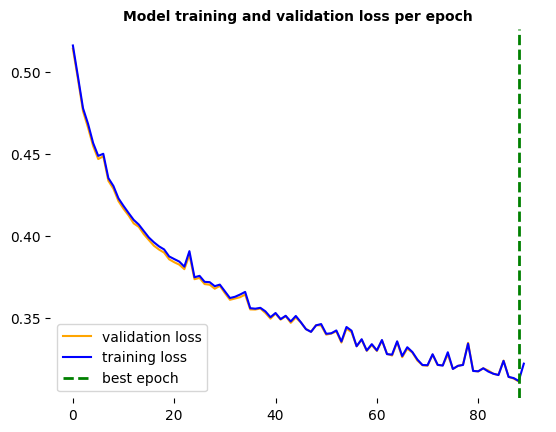

In [12]:
fig, ax = plt.subplots()
#fig.set_size_inches(30.5, 15.5)

plt.plot(validation_losses,color='orange',label='validation loss')
plt.plot(train_losses,color='blue',label='training loss')

plt.axvline(x=best_epoch, color="green", linewidth=2, linestyle='dashed',label='best epoch')
#plt.legend(['Val Loss', 'Train Loss', "Best Epoch"])
plt.legend()


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Model training and validation loss per epoch", fontsize=10, fontweight='bold')
#plt.ylim(0.05,0.2)
plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/{folder_pkl}/model_loss_{model_list[sel_alg]}_view_{view}lr001.png')
plt.show()

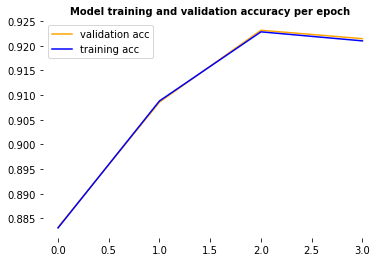

In [15]:
fig, ax = plt.subplots()
#fig.set_size_inches(30.5, 15.5)

plt.plot(validation_accuracies,color='orange',label='validation acc')
plt.plot(train_accuracies,color='blue',label='training acc')

plt.legend()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Model training and validation accuracy per epoch", fontsize=10, fontweight='bold')
# plt.ylim(0.9,1)
plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/{folder_pkl}/model_acc_{model_list[sel_alg]}_view_{view}.png')
plt.show()